In [1]:
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from tqdm import tqdm
import xgboost as xgb

# Data Prep

In [2]:
gender = 'M'

In [3]:
season = pd.read_csv(f'/kaggle/input/march-machine-learning-mania-2024/{gender}RegularSeasonDetailedResults.csv')
tournament = pd.read_csv(f'/kaggle/input/march-machine-learning-mania-2024/{gender}NCAATourneyDetailedResults.csv')

all_results = pd.concat([season, tournament]).reset_index(drop=True)

In [4]:
def prepare_boxscore_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [5]:
def create_training_data(regular_data,
                         seasons,
                         start_DayNum,
                         include_team_qual=False):
    
    # Basic group by features
    boxscore_cols = ['T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
                     'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
                     'PointDiff']
    funcs = ['mean']


    training_data_sets = []
    
    # Loop over each season
    for season in seasons:
        print(f'creating training data from {str(season)}')
        gameDayNums = regular_data[(regular_data['Season'] == season)]['DayNum'].unique()
        gameDayNums = gameDayNums[gameDayNums >= start_DayNum]
        
        # Loop over each game day
        for gameDayNum in gameDayNums:
            game_data = regular_data[(regular_data['Season'] == season) & (regular_data['DayNum'] == gameDayNum)].copy()
            stats_data = regular_data[(regular_data['Season'] == season) & (regular_data['DayNum'] < gameDayNum)].copy()

            # Create season level means
            season_statistics = stats_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
            season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

            season_statistics_T1 = season_statistics.copy()
            season_statistics_T2 = season_statistics.copy()

            season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
            season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
            season_statistics_T1.columns.values[0] = "Season"
            season_statistics_T2.columns.values[0] = "Season"

            # Collect win ratios for past 14 days

            last14days_stats_T1 = stats_data[stats_data['DayNum'] >= gameDayNum - 14].copy().reset_index(drop=True)
            last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
            last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

            last14days_stats_T2 = stats_data[stats_data['DayNum'] >= gameDayNum - 14].copy().reset_index(drop=True)
            last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
            last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

            # Skip quality for now

            # Merge together

            game_data = game_data[['Season', 'DayNum', 'location', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

            game_data = pd.merge(game_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
            game_data = pd.merge(game_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

            game_data = pd.merge(game_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
            game_data = pd.merge(game_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

            training_data_sets.append(game_data)
    
    return pd.concat(training_data_sets).reset_index(drop=True)

In [6]:
prepped_box_scores = prepare_boxscore_data(all_results)

In [7]:
seasons = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
           2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
training_data = create_training_data(prepped_box_scores,seasons, 70)

creating training data from 2003
creating training data from 2004
creating training data from 2005
creating training data from 2006
creating training data from 2007
creating training data from 2008
creating training data from 2009
creating training data from 2010
creating training data from 2011
creating training data from 2012
creating training data from 2013
creating training data from 2014
creating training data from 2015
creating training data from 2016
creating training data from 2017
creating training data from 2018
creating training data from 2019
creating training data from 2021
creating training data from 2022
creating training data from 2023
creating training data from 2024


In [8]:
training_data.shape

(118056, 47)

# Modeling

In [9]:
y = training_data['T1_Score'] - training_data['T2_Score']
y.describe()

count    118056.000000
mean          0.000000
std          13.431372
min         -62.000000
25%          -9.000000
50%           0.000000
75%           9.000000
max          62.000000
dtype: float64

In [10]:
features = list(training_data.columns[7:])
features.append('DayNum')
features.append('location')
len(features)

42

In [11]:
training_data[features].head()

,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,...,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,DayNum,location
0,24.000000,60.500000,7.400000,21.600000,12.900000,12.800000,20.800000,10.100000,20.200000,29.400000,...,17.083333,16.500000,17.250000,9.666667,4.333333,-32.583333,0.333333,0.00,70,-1
1,23.333333,57.166667,6.583333,18.416667,13.083333,11.666667,17.000000,8.833333,18.083333,23.000000,...,14.666667,17.777778,18.333333,6.111111,1.111111,-4.888889,0.750000,1.00,70,-1
2,30.375000,64.750000,7.750000,23.875000,10.750000,17.250000,17.500000,10.125000,18.000000,30.250000,...,12.700000,17.600000,17.400000,8.700000,3.600000,-3.100000,1.000000,0.75,70,-1
3,23.153846,52.615385,5.384615,16.461538,10.846154,13.230769,18.384615,7.538462,18.769231,26.615385,...,13.153846,14.153846,15.307692,8.769231,4.461538,-13.923077,0.333333,0.25,70,-1
4,23.285714,54.214286,4.428571,13.428571,11.214286,11.357143,18.071429,8.642857,20.714286,27.142857,...,14.200000,11.900000,18.000000,11.200000,4.300000,-9.800000,0.250000,0.25,70,-1


In [12]:
X = training_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [13]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [14]:
param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}


In [15]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:10.70117+0.00950	test-mae:10.70194+0.04083
[50]	train-mae:8.88889+0.00975	test-mae:8.90957+0.02615
[100]	train-mae:8.67895+0.00940	test-mae:8.70979+0.03132
[150]	train-mae:8.63134+0.00955	test-mae:8.67452+0.03435
[200]	train-mae:8.60644+0.00966	test-mae:8.66221+0.03530
[250]	train-mae:8.58794+0.00967	test-mae:8.65562+0.03580
[300]	train-mae:8.57216+0.00984	test-mae:8.65084+0.03618
[350]	train-mae:8.55805+0.00979	test-mae:8.64730+0.03646
[400]	train-mae:8.54440+0.00986	test-mae:8.64443+0.03649
[450]	train-mae:8.53187+0.00944	test-mae:8.64245+0.03676
[500]	train-mae:8.51961+0.00933	test-mae:8.64089+0.03665
[550]	train-mae:8.50795+0.00935	test-mae:8.63935+0.03671
[600]	train-mae:8.49677+0.00944	test-mae:8.63815+0.03652
[650]	train-mae:8.48561+0.00952	test-mae:8.63725+0.03630
[700]	train-mae:8.47528+0.00960	test-mae:8.63653+0.03650
[725]	train-mae:8.47006+0.00968	test-mae:8.63675+0.03656
Fold repeater 1
[0]	train-mae:10.70114+0.01033	test-mae:10.70147+0.04135


In [16]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae


([701, 930, 996], [8.636496908279808, 8.630966302525291, 8.634061885489762])

In [17]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.astype('float64').copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-25,25))

Fold repeater 0
Fold repeater 1
Fold repeater 2


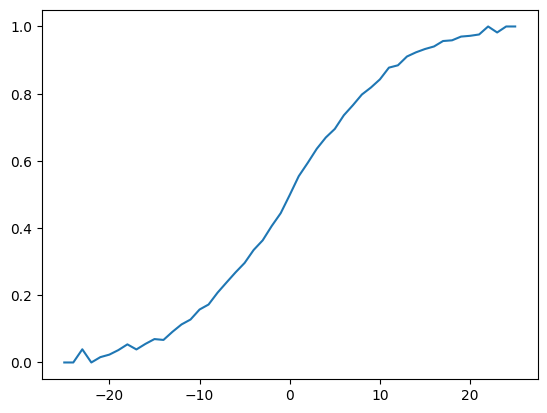

In [18]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [19]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5623652965461777
logloss of cvsplit 1: 0.5621592848126068
logloss of cvsplit 2: 0.5622157036721163


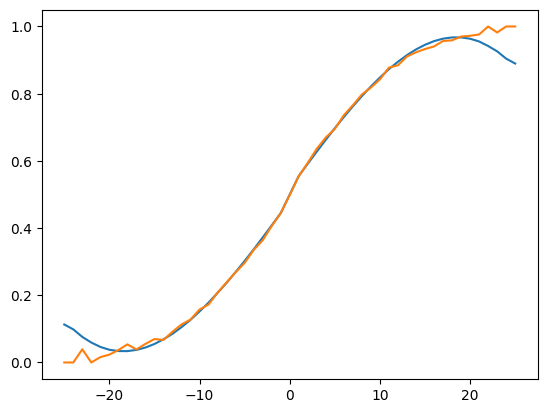

In [20]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [21]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5623652965461777
adjusted logloss of cvsplit 1: 0.5621592848126068
adjusted logloss of cvsplit 2: 0.5622157036721163


In [22]:
repeat_cv = 3

pred_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    pred_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2


# Make Predictions

In [23]:
seeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M'].copy()
seeds_w = seeds[seeds['Tournament'] == 'W'].copy()

seeds_m['TeamID'] = seeds_m['TeamID'].replace(1224, 1447)
seeds_m['TeamID'] = seeds_m['TeamID'].replace(1129, 1160)

In [24]:
# Pull the team data
stats_data = prepped_box_scores[prepped_box_scores['Season']==2024].copy()

In [25]:
# Create the team matchups
unique_teams = seeds_m['TeamID'].unique()
team_pairs = list(combinations(unique_teams, 2))

game_data_m = pd.DataFrame(team_pairs, columns=['T1_TeamID', 'T2_TeamID'])
game_data_m['Season'] = 2024
game_data_m['DayNum'] = stats_data['DayNum'].max()
game_data_m['location'] = 0

game_data_m.head()
print(len(game_data_m))

2016


In [26]:
def create_feature_data(game_data, stats_data):
    # Basic group by features
    boxscore_cols = ['T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
                     'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
                     'PointDiff']
    funcs = ['mean']

    gameDayNum = stats_data['DayNum'].max()
    
    # Create season level means
    season_statistics = stats_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
    season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

    season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
    season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
    season_statistics_T1.columns.values[0] = "Season"
    season_statistics_T2.columns.values[0] = "Season"

    # Collect win ratios for past 14 days

    last14days_stats_T1 = stats_data[stats_data['DayNum'] >= gameDayNum - 14].copy().reset_index(drop=True)
    last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
    last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

    last14days_stats_T2 = stats_data[stats_data['DayNum'] >= gameDayNum - 14].copy().reset_index(drop=True)
    last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
    last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

    # Skip quality for now

    # Merge together

    game_data = game_data[['Season', 'DayNum', 'location', 'T1_TeamID', 'T2_TeamID']]

    game_data = pd.merge(game_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    game_data = pd.merge(game_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

    game_data = pd.merge(game_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    game_data = pd.merge(game_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

    return game_data

In [27]:
feature_data = create_feature_data(game_data_m, stats_data)

In [28]:
X = feature_data[features].values
dtest = xgb.DMatrix(X)

In [29]:
preds = []
for i in range(repeat_cv):
    preds.append(np.clip(spline_model[i](np.clip(pred_models[i].predict(dtest),-19,19)),0.025,0.975))
mean_predctions = pd.DataFrame(preds).mean(axis=0)
mean_predctions.name = 'Pred'

In [30]:
preds_m = game_data_m[['T1_TeamID', 'T2_TeamID']].merge(mean_predctions, how='left', left_index=True, right_index=True)
preds_m.head()

,T1_TeamID,T2_TeamID,Pred
0,1163,1235,0.615906
1,1163,1228,0.737588
2,1163,1120,0.589064
3,1163,1361,0.839507
4,1163,1140,0.704246


# Data Prep

In [31]:
gender = 'W'

In [32]:
season = pd.read_csv(f'/kaggle/input/march-machine-learning-mania-2024/{gender}RegularSeasonDetailedResults.csv')
tournament = pd.read_csv(f'/kaggle/input/march-machine-learning-mania-2024/{gender}NCAATourneyDetailedResults.csv')

all_results = pd.concat([season, tournament]).reset_index(drop=True)

In [33]:
prepped_box_scores = prepare_boxscore_data(all_results)

In [34]:
seasons = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
training_data = create_training_data(prepped_box_scores,seasons, 70)

creating training data from 2010
creating training data from 2011
creating training data from 2012
creating training data from 2013
creating training data from 2014
creating training data from 2015
creating training data from 2016
creating training data from 2017
creating training data from 2018
creating training data from 2019
creating training data from 2021
creating training data from 2022
creating training data from 2023
creating training data from 2024


In [35]:
training_data.shape

(76400, 47)

# Modeling

In [36]:
y = training_data['T1_Score'] - training_data['T2_Score']
y.describe()

count    76400.000000
mean         0.000000
std         16.315302
min        -89.000000
25%        -11.000000
50%          0.000000
75%         11.000000
max         89.000000
dtype: float64

In [37]:
features = list(training_data.columns[7:])
features.append('DayNum')
features.append('location')
len(features)

42

In [38]:
X = training_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [39]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [40]:
param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}


In [41]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.00816+0.02768	test-mae:13.00928+0.11337
[50]	train-mae:9.95338+0.01394	test-mae:9.99129+0.06206
[100]	train-mae:9.59066+0.01350	test-mae:9.65020+0.05199
[150]	train-mae:9.49973+0.01417	test-mae:9.57865+0.05313
[200]	train-mae:9.45811+0.01409	test-mae:9.55648+0.05475
[250]	train-mae:9.42710+0.01474	test-mae:9.54517+0.05607
[300]	train-mae:9.40080+0.01424	test-mae:9.53664+0.05723
[350]	train-mae:9.37670+0.01475	test-mae:9.53003+0.05670
[400]	train-mae:9.35378+0.01473	test-mae:9.52404+0.05683
[450]	train-mae:9.33195+0.01480	test-mae:9.52007+0.05796
[500]	train-mae:9.31162+0.01487	test-mae:9.51591+0.05873
[550]	train-mae:9.29166+0.01522	test-mae:9.51159+0.06007
[600]	train-mae:9.27222+0.01517	test-mae:9.50753+0.05888
[650]	train-mae:9.25395+0.01513	test-mae:9.50453+0.05935
[700]	train-mae:9.23607+0.01502	test-mae:9.50173+0.05890
[750]	train-mae:9.21846+0.01498	test-mae:9.49913+0.05883
[800]	train-mae:9.20146+0.01520	test-mae:9.49769+0.05931
[850]	train-mae:

In [42]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae


([1349, 1237, 1430], [9.483035283899277, 9.48526110908124, 9.473474924203146])

In [43]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.astype('float64').copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2


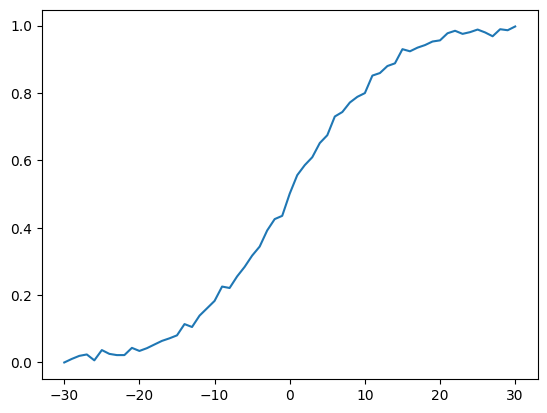

In [44]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [45]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5149000847090506
logloss of cvsplit 1: 0.5151385329646935
logloss of cvsplit 2: 0.5150469286648814


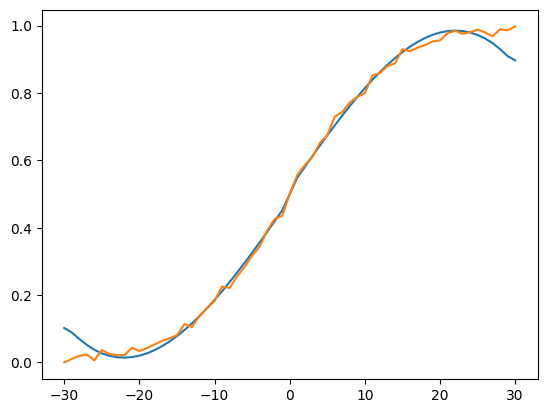

In [46]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [47]:
for n in range(-25,-15):
    print(n,spline_model[2]([n]))

-25 [0.02113236]
-24 [0.01582795]
-23 [0.01352332]
-22 [0.01409327]
-21 [0.01741262]
-20 [0.02335618]
-19 [0.03179878]
-18 [0.04261523]
-17 [0.05568034]
-16 [0.07086893]


In [48]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5147922204194207
adjusted logloss of cvsplit 1: 0.5150198208436415
adjusted logloss of cvsplit 2: 0.5149413377332809


In [49]:
repeat_cv = 3

pred_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    pred_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2


# Make Predictions

In [50]:
# Z12 3162 needs to be Vanderbilt, TeamID 3435
seeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M'].copy()
seeds_w = seeds[seeds['Tournament'] == 'W'].copy()

seeds_w['TeamID'] = seeds_w['TeamID'].replace(3162, 3435)

In [51]:
# Pull the team data
stats_data = prepped_box_scores[prepped_box_scores['Season']==2024].copy()

In [52]:
# Create the team matchups
unique_teams = seeds_w['TeamID'].unique()
team_pairs = list(combinations(unique_teams, 2))

game_data_w = pd.DataFrame(team_pairs, columns=['T1_TeamID', 'T2_TeamID'])
game_data_w['Season'] = 2024
game_data_w['DayNum'] = stats_data['DayNum'].max()
game_data_w['location'] = 0

game_data_w.head()
print(len(game_data_w))

2016


In [53]:
def create_feature_data(game_data, stats_data):
    # Basic group by features
    boxscore_cols = ['T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
                     'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
                     'PointDiff']
    funcs = ['mean']

    gameDayNum = stats_data['DayNum'].max()
    
    # Create season level means
    season_statistics = stats_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
    season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

    season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
    season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
    season_statistics_T1.columns.values[0] = "Season"
    season_statistics_T2.columns.values[0] = "Season"

    # Collect win ratios for past 14 days

    last14days_stats_T1 = stats_data[stats_data['DayNum'] >= gameDayNum - 14].copy().reset_index(drop=True)
    last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
    last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

    last14days_stats_T2 = stats_data[stats_data['DayNum'] >= gameDayNum - 14].copy().reset_index(drop=True)
    last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
    last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

    # Skip quality for now

    # Merge together

    game_data = game_data[['Season', 'DayNum', 'location', 'T1_TeamID', 'T2_TeamID']]

    game_data = pd.merge(game_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    game_data = pd.merge(game_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

    game_data = pd.merge(game_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    game_data = pd.merge(game_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

    return game_data

In [54]:
feature_data = create_feature_data(game_data_w, stats_data)

In [55]:
X = feature_data[features].values
dtest = xgb.DMatrix(X)

In [56]:
preds = []
for i in range(repeat_cv):
    preds.append(np.clip(spline_model[i](np.clip(pred_models[i].predict(dtest),-23,23)),0.025,0.975))
mean_predctions = pd.DataFrame(preds).mean(axis=0)
mean_predctions.name = 'Pred'

In [57]:
preds_w = game_data_w[['T1_TeamID', 'T2_TeamID']].merge(mean_predctions, how='left', left_index=True, right_index=True)
preds_w.head()

,T1_TeamID,T2_TeamID,Pred
0,3376,3323,0.813934
1,3376,3333,0.875312
2,3376,3231,0.809538
3,3376,3328,0.963028
4,3376,3304,0.970241


# Combine and Create Brackets

In [58]:
all_preds = pd.concat([preds_m,preds_w]).reset_index(drop=True)
all_preds['ID'] = ['2024_' + str(t1) + '_' + str(t2) for t1,t2 in zip(all_preds['T1_TeamID'],all_preds['T2_TeamID'])]
all_preds = all_preds[['ID', 'Pred']]

In [59]:
all_preds.head()

,ID,Pred
0,2024_1163_1235,0.615906
1,2024_1163_1228,0.737588
2,2024_1163_1120,0.589064
3,2024_1163_1361,0.839507
4,2024_1163_1140,0.704246


In [60]:
# Load and filter data
round_slots = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2023]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds = pd.read_csv('/kaggle/input/march-machine-learning-mania-2024/2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M'].copy()
seeds_w = seeds[seeds['Tournament'] == 'W'].copy()

seeds_m['TeamID'] = seeds_m['TeamID'].replace(1224, 1447)
seeds_m['TeamID'] = seeds_m['TeamID'].replace(1129, 1160)
seeds_w['TeamID'] = seeds_w['TeamID'].replace(3162, 3435)


all_preds['ID'] = all_preds['ID'].str.split('_')

In [61]:
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        team1, team2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
        proba = probas[str(team1)][str(team2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = [team1, team2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []
    
    # Precompute random-values
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, random_values[b-1], sim)
        
        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

In [62]:
n_brackets = 100000
result_m=run_simulation(brackets=n_brackets, seeds=seeds_m, preds=all_preds, round_slots=round_slots, sim=True)
result_m['Tournament'] = 'M'
result_w=run_simulation(brackets=n_brackets, seeds=seeds_w, preds=all_preds, round_slots=round_slots, sim=True)
result_w['Tournament'] = 'W'
submission = pd.concat([result_m, result_w])
submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']

100%|██████████| 100000/100000 [00:18<00:00, 5391.28it/s]


In [63]:
submission

,Bracket,Slot,Team,Tournament
RowId,,,,
0,1,R1W1,W01,M
1,1,R1W2,W02,M
2,1,R1W3,W03,M
3,1,R1W4,W04,M
4,1,R1W5,W05,M
...,...,...,...,...
12599995,100000,R4Y1,Y10,W
12599996,100000,R4Z1,Z03,W
12599997,100000,R5WX,W01,W


In [64]:
submission.to_csv('submission.csv')
submission

,Bracket,Slot,Team,Tournament
RowId,,,,
0,1,R1W1,W01,M
1,1,R1W2,W02,M
2,1,R1W3,W03,M
3,1,R1W4,W04,M
4,1,R1W5,W05,M
...,...,...,...,...
12599995,100000,R4Y1,Y10,W
12599996,100000,R4Z1,Z03,W
12599997,100000,R5WX,W01,W
